***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.1)** 32D>16D>8D (Coarse>Medium>FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- With $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\5_CU_BIRD
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "6" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  6
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Parameters

In [4]:
train_params = {"n_epochs" : 100,
                "batch_size": 16,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

# log directory

In [5]:
directory = sysenv.log_dir('5_CU_Bird/HD_CapsNet/Mod_3_1')

FOLDER CREATED =  ../../logs/5_CU_Bird/HD_CapsNet/Mod_3_1


# Import Dataset : CU BIRD

In [6]:
training_dataset,  test_dataset, val_dataset, tree, info = datasets.CU_Birds_200_2011(image_size=(64, 64), 
                                                                                  batch_size=train_params['batch_size'],
                                                                                  data_aug = 'mixup', # 'mixup'
                                                                                  data_normalizing = None) #'normalize'

In [7]:
for x,y in training_dataset.take(1):
    image_shape = x.shape[1:]
    coarse_label_shape = y[0].shape[1:]
    medium_label_shape = y[1].shape[1:]
    fine_label_shape = y[2].shape[1:]

## Learning Rate Decay Scheduler

In [8]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Model Architecture

## Loss Function

In [9]:
## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": info['Num_Coarse'],
                                "medium": info['Num_Medium'],
                                "fine": info['Num_Fine']})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [10]:
Matrix_coarse_to_medium_OneHot = tf.constant(info['Matrix_coarse_to_medium'], dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(info['Matrix_medium_to_fine'], dtype=tf.float32)

In [11]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_pred
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,
               number_of_classes_m, number_of_classes_f, C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=number_of_classes_m)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=number_of_classes_f)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Architecture

In [12]:
def get_compiled_model():
    
    ## Calling the HD-CapsNet Model
    model = models.HD_CapsNet_Mod_3_3(input_shape     = image_shape, 
                                      input_shape_yc  = coarse_label_shape,
                                      input_shape_ym  = medium_label_shape,
                                      input_shape_yf  = fine_label_shape, 
                                      no_coarse_class = info['Num_Coarse'], 
                                      no_medium_class = info['Num_Medium'], 
                                      no_fine_class   = info['Num_Fine'],
                                      PCap_n_dims     = 8, 
                                      SCap_f_dims     = 8, 
                                      SCap_m_dims     = 16, 
                                      SCap_c_dims     = 32)
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)
    
    ## Add Loss for Model
    model.add_loss(CustomLoss(y_true_c            = model.inputs[1], 
                              y_true_m            = model.inputs[2], 
                              y_true_f            = model.inputs[3], 
                              y_pred_c            = model.output[0], 
                              y_pred_m            = model.output[1], 
                              y_pred_f            = model.output[2], 
                              LW_C                = lossweight['coarse_lw'], 
                              LW_M                = lossweight['medium_lw'], 
                              LW_F                = lossweight['fine_lw'],
                              number_of_classes_m = info['Num_Medium'], 
                              number_of_classes_f = info['Num_Fine'], 
                              C_Weight            =0.2)
                  )
    
    ## Compile Model
    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'}
                 )
    return model

## Compile Model

In [13]:
model = get_compiled_model()

In [14]:
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['batch_normalization[0]

                                                                                                  
 prediction_medium (LengthLayer  (None, 123)         0           ['s_caps_medium[0][0]']          
 )                                                                                                
                                                                                                  
 prediction_fine (LengthLayer)  (None, 200)          0           ['s_caps_fine[0][0]']            
                                                                                                  
 tf.math.argmax_4 (TFOpLambda)  (None,)              0           ['input_yc[0][0]']               
                                                                                                  
 tf.cast (TFOpLambda)           (None,)              0           ['tf.math.argmax_4[0][0]']       
                                                                                                  
 tf.math.a

                                                                                                  
 tf.math.subtract_12 (TFOpLambd  (None, 200)         0           ['input_yf[0][0]']               
 a)                                                                                               
                                                                                                  
 tf.math.maximum_5 (TFOpLambda)  (None, 200)         0           ['tf.math.subtract_11[0][0]']    
                                                                                                  
 tf.math.multiply_3 (TFOpLambda  (None, 200)         0           ['tf.compat.v1.gather_3[0][0]',  
 )                                                                'prediction_fine[0][0]']        
                                                                                                  
 tf.math.multiply_1 (TFOpLambda  (None, 200)         0           ['tf.compat.v1.gather_1[0][0]',  
 )        

                                                                                                  
 tf.math.abs_3 (TFOpLambda)     (None,)              0           ['tf.math.subtract_3[0][0]']     
                                                                                                  
 tf.math.abs_1 (TFOpLambda)     (None,)              0           ['tf.math.subtract_1[0][0]']     
                                                                                                  
 tf.math.add (TFOpLambda)       (None, 39)           0           ['tf.math.multiply_6[0][0]',     
                                                                  'tf.math.multiply_8[0][0]']     
                                                                                                  
 tf.math.multiply_13 (TFOpLambd  (None,)             0           ['tf.math.reduce_sum_5[0][0]']   
 a)                                                                                               
          

## Data Augmentation

## Training Pipeline Alignment

In [15]:
#### Matching the pipeling with model inputs
def pipeline_multi_input_output(image, label):
    label_0 = label[0]
    label_1 = label[1]
    label_2 = label[2]
    return (image, label_0, label_1, label_2), (label_0, label_1, label_2)

training_dataset_match = training_dataset.map(pipeline_multi_input_output) ## Mixup dataset
val_dataset_match = val_dataset.map(pipeline_multi_input_output) ## Val Dataset

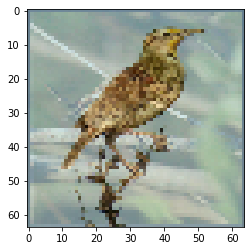

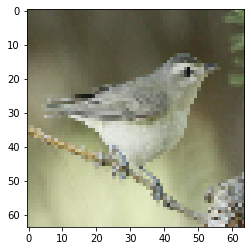

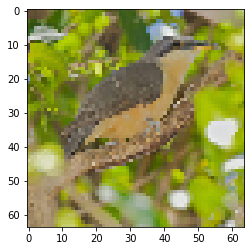

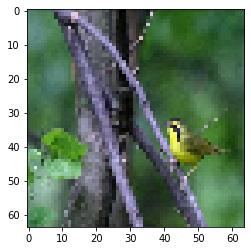

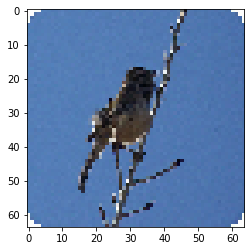

In [16]:
for x,y in training_dataset_match.take(5):
    plt.imshow(x[0][0])
    plt.show()
    

## Callback

In [17]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(directory+'/epoch-best.h5',
                                             monitor='val_prediction_fine_accuracy',
                                             save_best_only=True, 
                                             save_weights_only=True, 
                                             verbose=1)

change_lw = models.LossWeightsModifier(lossweight = lossweight,
                                       initial_lw = initial_lw,
                                       directory = directory)

lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [18]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_dataset_match,
                        epochs = train_params["n_epochs"],
                        validation_data = val_dataset_match,
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
375/375 [==============================] - ETA: 0s - loss: 0.6133 - prediction_coarse_accuracy: 0.1945 - prediction_medium_accuracy: 0.0727 - prediction_fine_accuracy: 0.0202
  • Coarse Accuracy = 19.45% | Val_Accuracy = 14.60% | LossWeight = 0.41 
  • Medium Accuracy = 7.27% | Val_Accuracy = 4.83% | LossWeight = 0.35 
  • Fine   Accuracy = 2.02% | Val_Accuracy = 0.93% | LossWeight = 0.25 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.00932, saving model to ../../logs/5_CU_Bird/HD_CapsNet/Mod_3_1\epoch-best.h5
375/375 [==============================] - 204s 469ms/step - loss: 0.6133 - prediction_coarse_accuracy: 0.1945 - prediction_medium_accuracy: 0.0727 - prediction_fine_accuracy: 0.0202 - val_loss: 0.6066 - val_prediction_coarse_accuracy: 0.1460 - val_prediction_medium_accuracy: 0.0483 - val_prediction_fine_accuracy: 0.0093 - lr: 0.0010
Epoch 2/100
375/375 [==============================] - ETA: 0s - loss: 0.5319 - prediction_coarse_accuracy: 0.2716 - pr

375/375 [==============================] - ETA: 0s - loss: 0.2189 - prediction_coarse_accuracy: 0.8909 - prediction_medium_accuracy: 0.8415 - prediction_fine_accuracy: 0.7431
  • Coarse Accuracy = 89.09% | Val_Accuracy = 38.73% | LossWeight = 0.31 
  • Medium Accuracy = 84.15% | Val_Accuracy = 21.88% | LossWeight = 0.33 
  • Fine   Accuracy = 74.31% | Val_Accuracy = 14.77% | LossWeight = 0.36 

Epoch 9: val_prediction_fine_accuracy improved from 0.13669 to 0.14774, saving model to ../../logs/5_CU_Bird/HD_CapsNet/Mod_3_1\epoch-best.h5
375/375 [==============================] - 192s 493ms/step - loss: 0.2189 - prediction_coarse_accuracy: 0.8909 - prediction_medium_accuracy: 0.8415 - prediction_fine_accuracy: 0.7431 - val_loss: 0.4314 - val_prediction_coarse_accuracy: 0.3873 - val_prediction_medium_accuracy: 0.2188 - val_prediction_fine_accuracy: 0.1477 - lr: 0.0010
Epoch 10/100
375/375 [==============================] - ETA: 0s - loss: 0.1891 - prediction_coarse_accuracy: 0.9144 - predic

375/375 [==============================] - 187s 476ms/step - loss: 0.1092 - prediction_coarse_accuracy: 0.9641 - prediction_medium_accuracy: 0.9668 - prediction_fine_accuracy: 0.9603 - val_loss: 0.5055 - val_prediction_coarse_accuracy: 0.3918 - val_prediction_medium_accuracy: 0.2302 - val_prediction_fine_accuracy: 0.1567 - lr: 6.6342e-04
Epoch 19/100
375/375 [==============================] - ETA: 0s - loss: 0.1009 - prediction_coarse_accuracy: 0.9690 - prediction_medium_accuracy: 0.9740 - prediction_fine_accuracy: 0.9681
  • Coarse Accuracy = 96.90% | Val_Accuracy = 40.04% | LossWeight = 0.47 
  • Medium Accuracy = 97.40% | Val_Accuracy = 23.20% | LossWeight = 0.29 
  • Fine   Accuracy = 96.81% | Val_Accuracy = 16.02% | LossWeight = 0.24 

Epoch 19: val_prediction_fine_accuracy did not improve from 0.17225
375/375 [==============================] - 188s 475ms/step - loss: 0.1009 - prediction_coarse_accuracy: 0.9690 - prediction_medium_accuracy: 0.9740 - prediction_fine_accuracy: 0.968

375/375 [==============================] - ETA: 0s - loss: 0.0890 - prediction_coarse_accuracy: 0.9723 - prediction_medium_accuracy: 0.9765 - prediction_fine_accuracy: 0.9726
  • Coarse Accuracy = 97.23% | Val_Accuracy = 39.97% | LossWeight = 0.47 
  • Medium Accuracy = 97.65% | Val_Accuracy = 21.37% | LossWeight = 0.30 
  • Fine   Accuracy = 97.26% | Val_Accuracy = 15.19% | LossWeight = 0.23 

Epoch 28: val_prediction_fine_accuracy did not improve from 0.17225
375/375 [==============================] - 190s 483ms/step - loss: 0.0890 - prediction_coarse_accuracy: 0.9723 - prediction_medium_accuracy: 0.9765 - prediction_fine_accuracy: 0.9726 - val_loss: 0.5120 - val_prediction_coarse_accuracy: 0.3997 - val_prediction_medium_accuracy: 0.2137 - val_prediction_fine_accuracy: 0.1519 - lr: 3.9721e-04
Epoch 29/100
375/375 [==============================] - ETA: 0s - loss: 0.0920 - prediction_coarse_accuracy: 0.9771 - prediction_medium_accuracy: 0.9770 - prediction_fine_accuracy: 0.9748
  • Co

375/375 [==============================] - 187s 472ms/step - loss: 0.0835 - prediction_coarse_accuracy: 0.9731 - prediction_medium_accuracy: 0.9728 - prediction_fine_accuracy: 0.9708 - val_loss: 0.5069 - val_prediction_coarse_accuracy: 0.4097 - val_prediction_medium_accuracy: 0.2188 - val_prediction_fine_accuracy: 0.1512 - lr: 2.5034e-04
Epoch 38/100
375/375 [==============================] - ETA: 0s - loss: 0.0850 - prediction_coarse_accuracy: 0.9730 - prediction_medium_accuracy: 0.9718 - prediction_fine_accuracy: 0.9701
  • Coarse Accuracy = 97.30% | Val_Accuracy = 41.87% | LossWeight = 0.43 
  • Medium Accuracy = 97.18% | Val_Accuracy = 22.47% | LossWeight = 0.33 
  • Fine   Accuracy = 97.01% | Val_Accuracy = 15.22% | LossWeight = 0.24 

Epoch 38: val_prediction_fine_accuracy did not improve from 0.17225
375/375 [==============================] - 188s 476ms/step - loss: 0.0850 - prediction_coarse_accuracy: 0.9730 - prediction_medium_accuracy: 0.9718 - prediction_fine_accuracy: 0.970

375/375 [==============================] - ETA: 0s - loss: 0.0829 - prediction_coarse_accuracy: 0.9731 - prediction_medium_accuracy: 0.9756 - prediction_fine_accuracy: 0.9713
  • Coarse Accuracy = 97.31% | Val_Accuracy = 41.42% | LossWeight = 0.45 
  • Medium Accuracy = 97.56% | Val_Accuracy = 22.54% | LossWeight = 0.30 
  • Fine   Accuracy = 97.13% | Val_Accuracy = 15.15% | LossWeight = 0.24 

Epoch 47: val_prediction_fine_accuracy did not improve from 0.17225
375/375 [==============================] - 190s 488ms/step - loss: 0.0829 - prediction_coarse_accuracy: 0.9731 - prediction_medium_accuracy: 0.9756 - prediction_fine_accuracy: 0.9713 - val_loss: 0.4894 - val_prediction_coarse_accuracy: 0.4142 - val_prediction_medium_accuracy: 0.2254 - val_prediction_fine_accuracy: 0.1515 - lr: 1.4989e-04
Epoch 48/100
375/375 [==============================] - ETA: 0s - loss: 0.0862 - prediction_coarse_accuracy: 0.9753 - prediction_medium_accuracy: 0.9748 - prediction_fine_accuracy: 0.9716
  • Co

375/375 [==============================] - 188s 481ms/step - loss: 0.0792 - prediction_coarse_accuracy: 0.9756 - prediction_medium_accuracy: 0.9753 - prediction_fine_accuracy: 0.9736 - val_loss: 0.4951 - val_prediction_coarse_accuracy: 0.4111 - val_prediction_medium_accuracy: 0.2247 - val_prediction_fine_accuracy: 0.1533 - lr: 9.4468e-05
Epoch 57/100
375/375 [==============================] - ETA: 0s - loss: 0.0830 - prediction_coarse_accuracy: 0.9770 - prediction_medium_accuracy: 0.9761 - prediction_fine_accuracy: 0.9746
  • Coarse Accuracy = 97.70% | Val_Accuracy = 40.84% | LossWeight = 0.43 
  • Medium Accuracy = 97.61% | Val_Accuracy = 22.47% | LossWeight = 0.33 
  • Fine   Accuracy = 97.46% | Val_Accuracy = 15.33% | LossWeight = 0.24 

Epoch 57: val_prediction_fine_accuracy did not improve from 0.17225
375/375 [==============================] - 191s 491ms/step - loss: 0.0830 - prediction_coarse_accuracy: 0.9770 - prediction_medium_accuracy: 0.9761 - prediction_fine_accuracy: 0.974

375/375 [==============================] - ETA: 0s - loss: 0.0806 - prediction_coarse_accuracy: 0.9763 - prediction_medium_accuracy: 0.9753 - prediction_fine_accuracy: 0.9713
  • Coarse Accuracy = 97.63% | Val_Accuracy = 41.59% | LossWeight = 0.42 
  • Medium Accuracy = 97.53% | Val_Accuracy = 22.33% | LossWeight = 0.32 
  • Fine   Accuracy = 97.13% | Val_Accuracy = 15.08% | LossWeight = 0.26 

Epoch 66: val_prediction_fine_accuracy did not improve from 0.17225
375/375 [==============================] - 193s 494ms/step - loss: 0.0806 - prediction_coarse_accuracy: 0.9763 - prediction_medium_accuracy: 0.9753 - prediction_fine_accuracy: 0.9713 - val_loss: 0.4966 - val_prediction_coarse_accuracy: 0.4159 - val_prediction_medium_accuracy: 0.2233 - val_prediction_fine_accuracy: 0.1508 - lr: 5.6562e-05
Epoch 67/100
375/375 [==============================] - ETA: 0s - loss: 0.0805 - prediction_coarse_accuracy: 0.9738 - prediction_medium_accuracy: 0.9750 - prediction_fine_accuracy: 0.9733
  • Co

375/375 [==============================] - 194s 492ms/step - loss: 0.0781 - prediction_coarse_accuracy: 0.9771 - prediction_medium_accuracy: 0.9756 - prediction_fine_accuracy: 0.9750 - val_loss: 0.4916 - val_prediction_coarse_accuracy: 0.4122 - val_prediction_medium_accuracy: 0.2209 - val_prediction_fine_accuracy: 0.1546 - lr: 3.5648e-05
Epoch 76/100
375/375 [==============================] - ETA: 0s - loss: 0.0797 - prediction_coarse_accuracy: 0.9761 - prediction_medium_accuracy: 0.9746 - prediction_fine_accuracy: 0.9748
  • Coarse Accuracy = 97.61% | Val_Accuracy = 41.15% | LossWeight = 0.43 
  • Medium Accuracy = 97.46% | Val_Accuracy = 22.13% | LossWeight = 0.34 
  • Fine   Accuracy = 97.48% | Val_Accuracy = 15.81% | LossWeight = 0.23 

Epoch 76: val_prediction_fine_accuracy did not improve from 0.17225
375/375 [==============================] - 185s 475ms/step - loss: 0.0797 - prediction_coarse_accuracy: 0.9761 - prediction_medium_accuracy: 0.9746 - prediction_fine_accuracy: 0.974

375/375 [==============================] - ETA: 0s - loss: 0.0807 - prediction_coarse_accuracy: 0.9731 - prediction_medium_accuracy: 0.9745 - prediction_fine_accuracy: 0.9718
  • Coarse Accuracy = 97.31% | Val_Accuracy = 41.11% | LossWeight = 0.45 
  • Medium Accuracy = 97.45% | Val_Accuracy = 21.85% | LossWeight = 0.32 
  • Fine   Accuracy = 97.18% | Val_Accuracy = 15.50% | LossWeight = 0.24 

Epoch 85: val_prediction_fine_accuracy did not improve from 0.17225
375/375 [==============================] - 188s 482ms/step - loss: 0.0807 - prediction_coarse_accuracy: 0.9731 - prediction_medium_accuracy: 0.9745 - prediction_fine_accuracy: 0.9718 - val_loss: 0.4959 - val_prediction_coarse_accuracy: 0.4111 - val_prediction_medium_accuracy: 0.2185 - val_prediction_fine_accuracy: 0.1550 - lr: 2.1344e-05
Epoch 86/100
375/375 [==============================] - ETA: 0s - loss: 0.0810 - prediction_coarse_accuracy: 0.9745 - prediction_medium_accuracy: 0.9720 - prediction_fine_accuracy: 0.9718
  • Co

375/375 [==============================] - 181s 463ms/step - loss: 0.0776 - prediction_coarse_accuracy: 0.9761 - prediction_medium_accuracy: 0.9753 - prediction_fine_accuracy: 0.9735 - val_loss: 0.4924 - val_prediction_coarse_accuracy: 0.4146 - val_prediction_medium_accuracy: 0.2209 - val_prediction_fine_accuracy: 0.1550 - lr: 1.3452e-05
Epoch 95/100
375/375 [==============================] - ETA: 0s - loss: 0.0801 - prediction_coarse_accuracy: 0.9766 - prediction_medium_accuracy: 0.9766 - prediction_fine_accuracy: 0.9761
  • Coarse Accuracy = 97.66% | Val_Accuracy = 41.04% | LossWeight = 0.44 
  • Medium Accuracy = 97.66% | Val_Accuracy = 22.06% | LossWeight = 0.33 
  • Fine   Accuracy = 97.61% | Val_Accuracy = 15.64% | LossWeight = 0.23 

Epoch 95: val_prediction_fine_accuracy did not improve from 0.17225
375/375 [==============================] - 183s 468ms/step - loss: 0.0801 - prediction_coarse_accuracy: 0.9766 - prediction_medium_accuracy: 0.9766 - prediction_fine_accuracy: 0.976

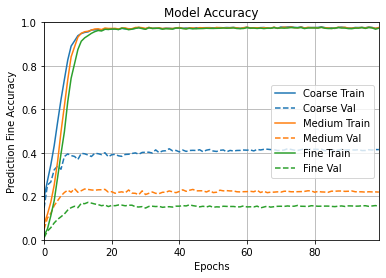

In [19]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

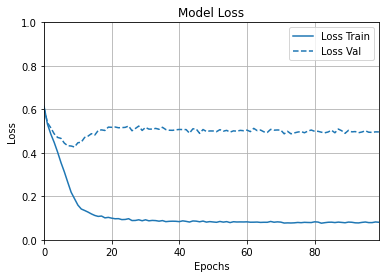

In [20]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [21]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

In [22]:
results = final_model.evaluate(test_dataset)
for n in range(len(results)):
    print(str(n+1)+'.',final_model.metrics_names[n], '==>', results[n])
model_predictions = final_model.predict(test_dataset)

182/182 [==============================] - 32s 153ms/step - loss: 0.5337 - prediction_coarse_loss: 0.4333 - prediction_medium_loss: 0.5854 - prediction_fine_loss: 0.6503 - prediction_coarse_accuracy: 0.4149 - prediction_medium_accuracy: 0.2195 - prediction_fine_accuracy: 0.1543
1. loss ==> 0.5336772799491882
2. prediction_coarse_loss ==> 0.43332159519195557
3. prediction_medium_loss ==> 0.5854277014732361
4. prediction_fine_loss ==> 0.6502748131752014
5. prediction_coarse_accuracy ==> 0.41491198539733887
6. prediction_medium_accuracy ==> 0.21953745186328888
7. prediction_fine_accuracy ==> 0.15429754555225372


In [26]:
def predict_from_pipeline(model, dataset):
    y_pred = []
    y_true = []
    for x, y in dataset:
        batch_pred = model.predict(x)
        for i in range(len(batch_pred)):
            if i >= len(y_pred):
                y_pred.append(None)
                y_true.append(None)
            if y_pred[i] is None:
                y_pred[i] = batch_pred[i]
                y_true[i] = list(y[i].numpy())
            else:
                y_pred[i] = np.concatenate([y_pred[i], batch_pred[i]])
                y_true[i] = y_true[i] + list(y[i].numpy())
    return y_true, y_pred

In [27]:
predictions = []
predictions.append(predict_from_pipeline(final_model, test_dataset))

In [29]:
dataset= {'y_test_coarse':predictions[0][0][0], 
          'y_test_medium':predictions[0][0][1], 
          'y_test_fine':predictions[0][0][2]}

In [30]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0][1][0],predictions[0][1][1],predictions[0][1][2]]

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 2  0  0 ...  0  0  0]
 [ 0 23  6 ...  1  0  0]
 [ 0  3 27 ...  0  0  0]
 ...
 [ 1  1  1 ... 15 10  3]
 [ 0  1  0 ...  3 49  5]
 [ 0  0  0 ...  2  7 15]]

  • MEDIUM LEVEL 
[[ 7  0  0 ...  0  0  0]
 [ 0 12  0 ...  0  0  0]
 [ 0  0  4 ...  0  0  0]
 ...
 [ 0  1  0 ... 21  0  2]
 [ 0  0  0 ...  0  9  0]
 [ 0  0  0 ...  3  0  2]]

  • FINE LEVEL 
[[3 0 2 ... 0 0 0]
 [1 2 0 ... 0 0 0]
 [0 1 4 ... 0 0 0]
 ...
 [0 1 0 ... 2 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 3]]

  • Classification Report 


  • COARSE LEVEL 


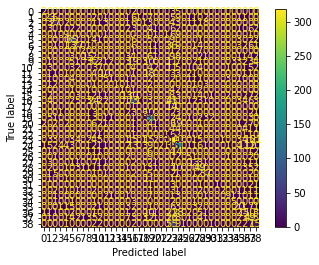

              precision    recall  f1-score   support

           0    0.33333   0.14286   0.20000        14
           1    0.35385   0.34328   0.34848        67
           2    0.47368   0.40909   0.43902        66
           3    0.14286   0.02857   0.04762        35
           4    0.36000   0.31034   0.33333        29
           5    0.55556   0.65000   0.59908       100
           6    0.51923   0.23894   0.32727       113
           7    0.50000   0.13333   0.21053        15
           8    0.42857   0.24194   0.30928        62
           9    0.26667   0.27119   0.26891       118
          10    0.22581   0.12069   0.15730        58
          11    0.32258   0.21277   0.25641        47
          12    0.20000   0.04348   0.07143        23
          13    1.00000   0.08333   0.15385        12
          14    1.00000   0.08333   0.15385        12
          15    0.28261   0.19697   0.23214        66
          16    0.37629   0.37056   0.37340       197
          17    0.00000   0

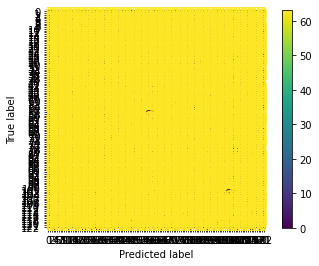

              precision    recall  f1-score   support

           0    0.43750   0.35000   0.38889        20
           1    0.35294   0.44444   0.39344        27
           2    0.36364   0.36364   0.36364        11
           3    0.20000   0.11111   0.14286         9
           4    0.00000   0.00000   0.00000        14
           5    0.20588   0.16667   0.18421        42
           6    0.10000   0.07692   0.08696        13
           7    0.54545   0.40000   0.46154        15
           8    0.25000   0.06250   0.10000        16
           9    0.35714   0.31250   0.33333        16
          10    0.00000   0.00000   0.00000        16
          11    0.11111   0.12500   0.11765        16
          12    0.18182   0.11429   0.14035        35
          13    0.10526   0.11765   0.11111        17
          14    0.00000   0.00000   0.00000         9
          15    0.09677   0.07317   0.08333        41
          16    0.25000   0.20000   0.22222        10
          17    0.57143   0

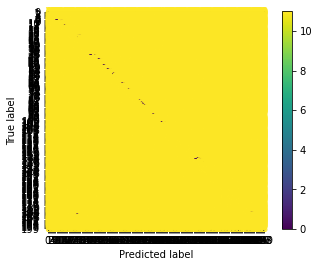

              precision    recall  f1-score   support

           0    0.21429   0.20000   0.20690        15
           1    0.15385   0.12500   0.13793        16
           2    0.40000   0.25000   0.30769        16
           3    0.05000   0.07692   0.06061        13
           4    0.11111   0.14286   0.12500         7
           5    0.20000   0.50000   0.28571         4
           6    0.30769   0.25000   0.27586        16
           7    0.17647   0.30000   0.22222        10
           8    0.05882   0.08333   0.06897        12
           9    0.41667   0.45455   0.43478        11
          10    0.07692   0.05882   0.06667        17
          11    0.47826   0.84615   0.61111        13
          12    0.21053   0.33333   0.25806        12
          13    0.10526   0.15385   0.12500        13
          14    0.00000   0.00000   0.00000        16
          15    0.42857   0.40000   0.41379        15
          16    0.07692   0.10000   0.08696        10
          17    0.14286   0

In [31]:
metrics.lvl_wise_metric(true_label,pred_label)

In [32]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,pred_label,tree)
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.24733057185594293 
Hierarchical Recall = 0.31469336094810724 
Hierarchical F1-Score = 0.2727191785700588 
Consistency =  0.2806351397997929 
Exact Match =  0.08940283051432517
